<a href="https://colab.research.google.com/github/MarianoChic09/MSc-AI-taller-de-deep-learning/blob/main/MSc_AI_ORT_Taller_IA_Tarea1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller de Deep Learning - Tarea 1

Introducción:
El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

Dataset:
El dataset a ser utilizado consiste de más de 13.000 imágenes de entrenamiento agrupadas
en 6 posibles “escenarios”: edificios, bosques, glaciares, montañas, océanos, calles.
Pueden descargarlo en el siguiente link.
El mismo contiene dos carpetas (train_set y test_set) donde las imágenes están
agrupadas en sub carpetas de acuerdo a su categoría.

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
! cp -r "/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification" .
! unzip -q scene_classification.zip
! rm scene_classification.zip

unzip:  cannot find or open scene_classification.zip, scene_classification.zip.zip or scene_classification.zip.ZIP.
rm: cannot remove 'scene_classification.zip': No such file or directory


In [ ]:
#%cd "/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification"
#%ls

/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification
test_set/  train_set/


## Cargando el dataset

In [21]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification")

In [22]:
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification


In [24]:
print(os.listdir())
# os.chdir("./data/imgs")
# print(os.listdir())
# os.chdir("../../")

['train_set', 'test_set']


In [25]:
import os

print("Directorio actual:", os.getcwd())
# print("\nContenido de 'train_set':", os.listdir("train_set"))

Directorio actual: /content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification


In [26]:
# Reemplaza 'class_1' con el nombre de uno de tus subdirectorios.
print("Contenido de 'train_set/buildings':", os.listdir("train_set/buildings"))

Contenido de 'train_set/buildings': ['19513.jpg', '19447.jpg', '19456.jpg', '1959.jpg', '19460.jpg', '1954.jpg', '19584.jpg', '1964.jpg', '19638.jpg', '19608.jpg', '19455.jpg', '19526.jpg', '19416.jpg', '19556.jpg', '19623.jpg', '19446.jpg', '19407.jpg', '1943.jpg', '19466.jpg', '2059.jpg', '2099.jpg', '1979.jpg', '2170.jpg', '19901.jpg', '19778.jpg', '19969.jpg', '19830.jpg', '19923.jpg', '20048.jpg', '19913.jpg', '2083.jpg', '19895.jpg', '19649.jpg', '19848.jpg', '2076.jpg', '19976.jpg', '2136.jpg', '19728.jpg', '19806.jpg', '19963.jpg', '19996.jpg', '19855.jpg', '20027.jpg', '1977.jpg', '20054.jpg', '20011.jpg', '19713.jpg', '2144.jpg', '19802.jpg', '2002.jpg', '19915.jpg', '19701.jpg', '19896.jpg', '2038.jpg', '19674.jpg', '19689.jpg', '2108.jpg', '19973.jpg', '19661.jpg', '2171.jpg', '19776.jpg', '19846.jpg', '19910.jpg', '2158.jpg', '19816.jpg', '19874.jpg', '19789.jpg', '20017.jpg', '2114.jpg', '2088.jpg', '19666.jpg', '19722.jpg', '2069.jpg', '19800.jpg', '19735.jpg', '19978.jp

In [27]:
all_extensions = set()  # Para almacenar todas las extensiones encontradas

# Iterar sobre cada subdirectorio en "train_set"
for folder in os.listdir("train_set"):
    # Determinar las extensiones de archivos en el subdirectorio actual
    extensions = {os.path.splitext(file)[1].lower() for file in os.listdir(f"train_set/{folder}")}
    all_extensions.update(extensions)

    print(f"Para la carpeta {folder}:")
    print(extensions)
    print("-" * 50)

print("Todas las extensiones encontradas:", all_extensions)

Para la carpeta street:
{'.jpg'}
--------------------------------------------------
Para la carpeta forest:
{'.jpg'}
--------------------------------------------------
Para la carpeta mountain:
{'.jpg'}
--------------------------------------------------
Para la carpeta buildings:
{'.jpg'}
--------------------------------------------------
Para la carpeta glacier:
{'.jpg'}
--------------------------------------------------
Para la carpeta sea:
{'.jpg'}
--------------------------------------------------
Todas las extensiones encontradas: {'.jpg'}


In [35]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import torch

class CustomCNN(nn.Module):
  def __init__(self, in_channels,number_classes):
    # in_channels: int, cantidad de canales de la imagen original
    super(CustomCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels = 32, kernel_size = 3,padding=1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3,padding=1)
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3,padding=1)
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3,padding=1)
    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 120, kernel_size = 3,padding=1)

    self.linear1 = nn.Linear(in_features = 120*18*18, out_features = 512)
    self.linear2 = nn.Linear(in_features = 512, out_features = number_classes)

    self.max_pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = self.max_pooling(out)

    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))
    out = self.max_pooling(out)

    out = F.relu(self.conv5(out))
    out = self.max_pooling(out)

    out = self.dropout(out).flatten(1)

    out = F.relu(self.linear1(out))
    out = self.dropout(out)
    out = self.linear2(out)
    return out

In [36]:
# def get_dataloaders(train_dataset, test_dataset, batch_size):

#     train_size = int(0.8 * len(train_dataset))
#     valid_size = len(train_dataset) - train_size
#     train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

#     return train_loader, valid_loader, test_loader

def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in loader:
      all_labels.extend(labels.numpy())

      optim.zero_grad()

      predictions = training_model(images.to(device))
      all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

      loss = criterion(predictions, labels.to(device))

      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
      for images, labels in loader:
        all_labels.extend(labels.numpy())

        predictions = val_model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        loss = criterion(predictions, labels.to(device))

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def train_model(model, train_loader, test_loader, criterion, optim, number_epochs):
  train_history = []
  test_history = []
  accuracy_history = []

  for epoch in range(number_epochs):
      start_time = time.time()

      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

      start_time = time.time()
      test_loss, acc = validation_epoch(model, test_loader, criterion)
      test_history.append(test_loss)
      accuracy_history.append(acc)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, test_loss, acc, time.time() - start_time))

def test_model(test_model, loader, criterion):
    test_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            all_labels.extend(labels.numpy())

            predictions = test_model(images.to(device))
            all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

            loss = criterion(predictions, labels.to(device))
            epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [60]:
import os

# Path to the dataset directory
dataset_dir = './train_set'

# Initialize a dictionary to hold the count of images in each class
class_distribution = {}

# Loop over all class directories
for class_dir in os.listdir(dataset_dir):
    class_dir_path = os.path.join(dataset_dir, class_dir)

    # Check if the current item is a directory
    if os.path.isdir(class_dir_path):

        # Count the number of image files in the class directory
        img_count = len([f for f in os.listdir(class_dir_path) if os.path.isfile(os.path.join(class_dir_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        # Update the class distribution dictionary
        class_distribution[class_dir] = img_count

# Print the class distribution
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")

street: 2382
forest: 2271
mountain: 2512
buildings: 2191
glacier: 2404
sea: 2274


# Augmentations

Entreno el Custom CNN con un "baseline" sin transformaciones y despues otro agregando algunas de estas transformaciones para comparar y ver si mejora el accuracy.

## "Baseline"

In [42]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 1. Setup the transformations and datasets
# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define your transformations
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resizing to ensure all images are the same size
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resizing to ensure all images are the same size
    transforms.ToTensor()
])

# Define your datasets using the transformations
train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

# 2. Create dataloaders using your dataset splits
BATCH_SIZE = 10

# Split the train_dataset into train and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

# Create your dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

#
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Global models config

BATCH_SIZE = 10
LR = 0.001
NUMBER_EPOCHS = 5
criterion = nn.CrossEntropyLoss().to(device)

# 3. Define and train your model
# Assuming you've already defined CustomCNN, criterion, and other functions earlier.
modelo_sin_aug = CustomCNN(3, 6).to(device)
optimizer = torch.optim.Adam(modelo_sin_aug.parameters(), lr=LR)

# Now, you can train your model
train_model(modelo_sin_aug, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS)

11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.095695 | Accuracy 55.12% | Time 55.84 seconds
Validation epoch 1 | Loss 0.860626 | Accuracy 65.76% | Time 7.76 seconds
Training epoch 2 | Loss 0.769056 | Accuracy 70.52% | Time 52.07 seconds
Validation epoch 2 | Loss 0.663934 | Accuracy 74.63% | Time 7.30 seconds
Training epoch 3 | Loss 0.623766 | Accuracy 76.44% | Time 52.63 seconds
Validation epoch 3 | Loss 0.568258 | Accuracy 79.19% | Time 7.75 seconds
Training epoch 4 | Loss 0.551290 | Accuracy 79.81% | Time 52.53 seconds
Validation epoch 4 | Loss 0.511140 | Accuracy 81.47% | Time 7.70 seconds
Training epoch 5 | Loss 0.497127 | Accuracy 82.01% | Time 52.14 seconds
Validation epoch 5 | Loss 0.518234 | Accuracy 81.87% | Time 7.45 seconds


In [43]:
test_loss, test_accuracy = test_model(modelo_sin_aug, test_loader, criterion)
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))

Test Loss: 0.509489
Test Accuracy: 81.87%


## Modelo con Augmentations

In [61]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 1. Setup the transformations and datasets
# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define your transformations
train_transform_normal = transforms.Compose([
    transforms.Resize((150, 150)),  # Resizing to ensure all images are the same size
    transforms.ToTensor()
])

train_transform  = transforms.Compose([
    #transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # Random Resized Crop
    # transforms.RandomRotation(15),  # Random Rotation by 15 degrees
    # transforms.RandomHorizontalFlip(),  # Random Horizontal Flip
    transforms.Resize((150, 150)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.25, 1.25), shear=15),  # Equivalent to rotation, width_shift, height_shift, zoom, and shear
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color Jitter
    transforms.ToTensor(),  # Convert PIL Image to Torch Tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)  # Random Erasing
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resizing to ensure all images are the same size
    transforms.ToTensor()
])

# Define your datasets using the transformations
train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

# 2. Create dataloaders using your dataset splits
BATCH_SIZE = 10

# Split the train_dataset into train and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

# Create your dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

#
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Global models config

BATCH_SIZE = 10
LR = 0.001
NUMBER_EPOCHS = 5
criterion = nn.CrossEntropyLoss().to(device)

# 3. Define and train your model
# Assuming you've already defined CustomCNN, criterion, and other functions earlier.
modelo_con_aug = CustomCNN(3, 6).to(device)
optimizer = torch.optim.Adam(modelo_con_aug.parameters(), lr=LR)

# Now, you can train your model
train_model(modelo_con_aug, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS)


11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.792603 | Accuracy 17.43% | Time 92.69 seconds
Validation epoch 1 | Loss 1.790453 | Accuracy 16.85% | Time 15.80 seconds
Training epoch 2 | Loss 1.791159 | Accuracy 18.10% | Time 87.05 seconds
Validation epoch 2 | Loss 1.792067 | Accuracy 16.85% | Time 15.92 seconds
Training epoch 3 | Loss 1.791119 | Accuracy 17.97% | Time 86.88 seconds
Validation epoch 3 | Loss 1.792298 | Accuracy 16.85% | Time 16.05 seconds
Training epoch 4 | Loss 1.791181 | Accuracy 17.90% | Time 85.25 seconds
Validation epoch 4 | Loss 1.792109 | Accuracy 16.85% | Time 15.50 seconds
Training epoch 5 | Loss 1.791012 | Accuracy 18.16% | Time 86.24 seconds
Validation epoch 5 | Loss 1.791575 | Accuracy 16.85% | Time 15.57 seconds


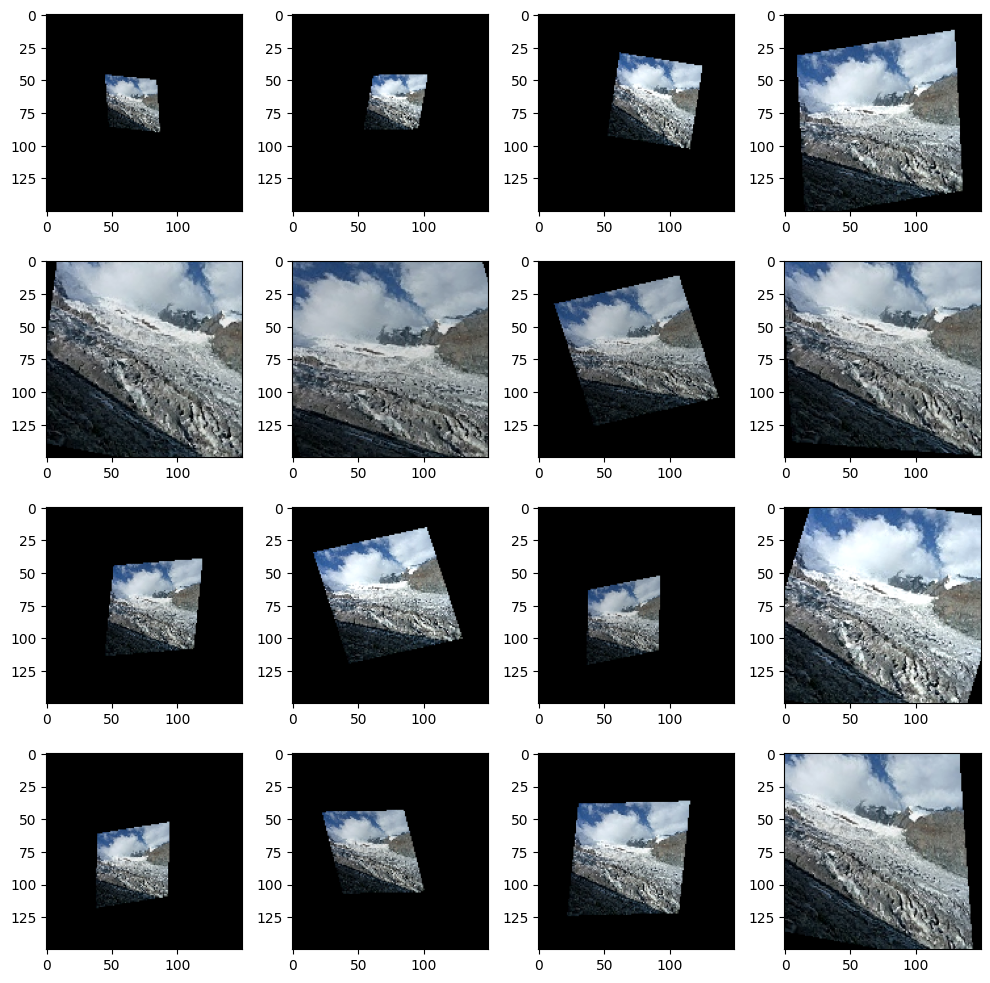

In [58]:
from PIL import Image
image_path = "/content/scene_classification/train_set/buildings/10006.jpg"
image_path_1 = "/content/scene_classification/train_set/glacier/10003.jpg"
image_path_2 = "/content/scene_classification/train_set/buildings/10006.jpg"

img = Image.open(image_path_1).convert("RGB")
img = img.resize((150, 150))

# Define the transformations
transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.25, 1.25), shear=15),  # Equivalent to rotation, width_shift, height_shift, zoom, and shear
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color Jitter
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply the transformations and plot the images
plt.figure(figsize=(10, 10))
for i in range(1, 17):
    plt.subplot(4, 4, i)
    transformed_img = transform(img)
    plt.imshow(transformed_img)

plt.tight_layout()
plt.show()

--------

In [41]:
test_loss, test_accuracy = test_model(modelo_con_aug, test_loader, criterion)
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))


Test Loss: 1.443414
Test Accuracy: 47.47%


# Dense Net

In [ ]:
import math
def compute_same_padding(input_shape, strides, kernel_size):
    padding_total = (input_shape*strides-input_shape-strides+kernel_size)/2
    return math.ceil(padding_total/2)

In [ ]:
class CompositeFunction(nn.Module):
    #BatchNorm + Relu + Conv
    def __init__(self, in_channels, out_channels, kernel_size, input_shape, strides = 1):
        super(CompositeFunction, self).__init__()
        self.bn = nn.BatchNorm2d(num_features = in_channels)
        P = compute_same_padding(input_shape, strides, kernel_size)
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = P)

    def forward(self, x):
        out = self.bn(x)
        out = self.conv(F.relu(out))
        return out

In [ ]:
class DenseBlock(nn.Module):
  #out_channels = in_channels + k * reps
  #bottleneck = 4*k
  def __init__(self, in_channels, reps, k, input_shape):
    super(DenseBlock, self).__init__()
    # Su implementacion
    self.reps = reps
    self.convs = []
    for i in range(reps):
        self.convs.append(CompositeFunction(in_channels+k*i, 4*k, 1, input_shape))
        self.convs.append(CompositeFunction(4*k, k, 3, input_shape))

    self.convs = nn.ModuleList(self.convs)

  def forward(self, x):
    for i in range(self.reps):
        x1 = self.convs[2*i](x)
        x2 = self.convs[2*i+1](x1)
        x = torch.cat([x,x2],1)
    return x

In [ ]:
class TransitionLayer(nn.Module):
  def __init__(self, in_channels, out_channels, input_shape):
    super(TransitionLayer, self).__init__()
    self.comp = CompositeFunction(in_channels, out_channels, 1, input_shape)
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    out = self.comp(x)
    out = self.pool(out)
    return out

In [ ]:
class DenseNet(nn.Module):
    #DenseNet 121
    def __init__(self, n_classes, input_shape, k):
        super(DenseNet, self).__init__()
        self.input_conv = CompositeFunction(in_channels = 3, out_channels = 2*k ,kernel_size = 7, input_shape = input_shape, strides = 2)
        self.input_max_pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.dense_block1 = DenseBlock(2*k, 6, k, int(input_shape/2))
        self.transitionLayer1 = TransitionLayer(in_channels=(6+2)*k, out_channels=4*k,  input_shape = int(input_shape/2))

        self.dense_block2 = DenseBlock(4*k, 12, k, int(input_shape/4))
        self.transitionLayer2 = TransitionLayer(in_channels=(12+4)*k, out_channels=8*k, input_shape =int(input_shape/4))

        self.dense_block3 = DenseBlock(8*k, 24, k, int(input_shape/8))
        self.transitionLayer3 = TransitionLayer(in_channels=(24+8)*k, out_channels=16*k, input_shape =int(input_shape/8))

        self.dense_block4 = DenseBlock(16*k, 16, k, input_shape =int(input_shape/16))
        last_number_of_filters = 16*k+16*k
        # Classifier
        h = int(input_shape/16)
        w = h
        self.fully_connected_1 = nn.Linear(last_number_of_filters*w*h, 512)
        self.output = nn.Linear(512, n_classes)


    def forward(self, x):
        out = self.input_conv(x)
        out = self.input_max_pooling(out)
        out = self.dense_block1(out)
        out = self.transitionLayer1(out)
        out = self.dense_block2(out)
        out = self.transitionLayer2(out)
        out = self.dense_block3(out)
        out = self.transitionLayer3(out)
        out = self.dense_block4(out)
        out = out.flatten(1)
        out = F.relu(self.fully_connected_1(out))
        out = self.output(out)

        return out

In [ ]:
densenet = DenseNet(6, 150, 4).to(device)
optimizer = torch.optim.Adam(densenet.parameters(), lr=LR)

In [ ]:
train_model(densenet, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS)

RuntimeError: ignored

# ResNet


### Deep Residual Learning for Image Recognition
Paper: https://arxiv.org/pdf/1512.03385.pdf

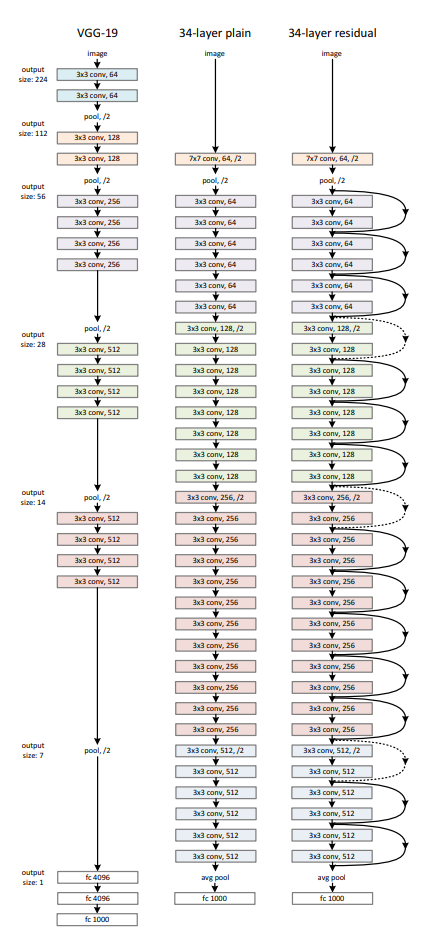

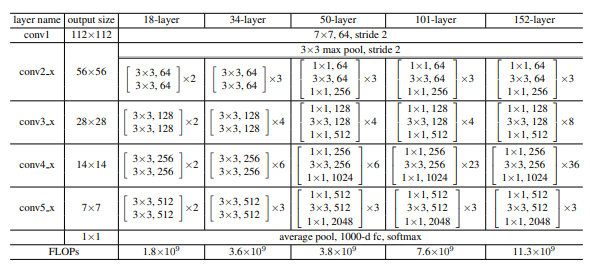

In [ ]:
# class Block(nn.module):


In [15]:
import torch
import torch.nn as nn
from torchsummary import summary

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
      super(Bottleneck, self).__init__()
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample

  def forward(self, x):
      residual = x
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.conv2(out)
      out = self.bn2(out)
      out = self.relu(out)
      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample:
          residual = self.downsample(x)

      out += residual
      out = self.relu(out)
      return out


class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000):
      super(ResNet, self).__init__()
      self.in_channels = 64
      self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
      self.bn1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU(inplace=True)
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.layer1 = self._make_layer(block, 64, layers[0])
      self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
      self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
      self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):
      downsample = None
      if stride != 1 or self.in_channels != out_channels * block.expansion:
          downsample = nn.Sequential(
              nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(out_channels * block.expansion)
          )
      layers = []
      layers.append(block(self.in_channels, out_channels, stride, downsample))
      self.in_channels = out_channels * block.expansion
      for i in range(1, blocks):
          layers.append(block(self.in_channels, out_channels))

      return nn.Sequential(*layers)

  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.fc(x)
      return x


def resnet50(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 6, 3], num_classes = num_classes)

def resnet101(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 23, 3], num_classes = num_classes)

def resnet152(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 36, 3], num_classes = num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet50 = resnet50(num_classes = 10).to(device)

summary(model_resnet50,input_size=(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,096
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,384
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,384
      BatchNorm2d-14          [-1, 256,

In [31]:
# def get_dataloaders(train_dataset, test_dataset, batch_size):

#     train_size = int(0.8 * len(train_dataset))
#     valid_size = len(train_dataset) - train_size
#     train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

#     return train_loader, valid_loader, test_loader

def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in loader:
      all_labels.extend(labels.numpy())

      optim.zero_grad()

      predictions = training_model(images.to(device))
      all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

      loss = criterion(predictions, labels.to(device))

      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
      for images, labels in loader:
        all_labels.extend(labels.numpy())

        predictions = val_model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        loss = criterion(predictions, labels.to(device))

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def train_model(model, train_loader, test_loader, criterion, optim, number_epochs):
  train_history = []
  test_history = []
  accuracy_history = []

  for epoch in range(number_epochs):
      start_time = time.time()

      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

      start_time = time.time()
      test_loss, acc = validation_epoch(model, test_loader, criterion)
      test_history.append(test_loss)
      accuracy_history.append(acc)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, test_loss, acc, time.time() - start_time))

def test_model(test_model, loader, criterion):
    test_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            all_labels.extend(labels.numpy())

            predictions = test_model(images.to(device))
            all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

            loss = criterion(predictions, labels.to(device))
            epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [33]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 1. Setup the transformations and datasets
# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define your transformations
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resizing to ensure all images are the same size
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resizing to ensure all images are the same size
    transforms.ToTensor()
])

# Define your datasets using the transformations
train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

# 2. Create dataloaders using your dataset splits
BATCH_SIZE = 10

# Split the train_dataset into train and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

# Create your dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

#
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Global models config

BATCH_SIZE = 10
LR = 0.001
NUMBER_EPOCHS = 15
criterion = nn.CrossEntropyLoss().to(device)

# 3. Define and train your model
# Assuming you've already defined CustomCNN, criterion, and other functions earlier.
# modelo_sin_aug = CustomCNN(3, 10).to(device)
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=LR)

# Now, you can train your model
train_model(model_resnet50, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS)


11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.181056 | Accuracy 55.24% | Time 97.94 seconds
Validation epoch 1 | Loss 1.239240 | Accuracy 55.08% | Time 9.84 seconds
Training epoch 2 | Loss 0.849673 | Accuracy 68.09% | Time 96.50 seconds
Validation epoch 2 | Loss 0.941780 | Accuracy 65.87% | Time 9.79 seconds
Training epoch 3 | Loss 0.744121 | Accuracy 71.80% | Time 96.61 seconds
Validation epoch 3 | Loss 0.722827 | Accuracy 74.53% | Time 9.82 seconds
Training epoch 4 | Loss 0.681500 | Accuracy 74.74% | Time 97.22 seconds
Validation epoch 4 | Loss 0.673035 | Accuracy 74.60% | Time 9.69 seconds
Training epoch 5 | Loss 0.620987 | Accuracy 77.13% | Time 96.61 seconds
Validation epoch 5 | Loss 0.609392 | Accuracy 77.84% | Time 9.76 seconds
Training epoch 6 | Loss 0.565240 | Accuracy 79.48% | Time 96.89 seconds
Validation epoch 6 | Loss 0.641757 | Accuracy 77.16% | Time 9.77 seconds
Training epoch 7 | Loss 0.533498 | Accuracy 80.60% | Time 96.83 seconds
Valid

In [34]:
test_loss, test_accuracy = test_model(modelo_sin_aug, test_loader, criterion)
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))


Test Loss: 0.732807
Test Accuracy: 78.57%
